In [1]:
! pip install -q datasets tqdm

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import collections
import random
import os
import time
import json
from PIL import Image
import io
import urllib
import uuid
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
iso639_3_letter_code = "hau"
# iso639_3_letter_code = "tha"
# iso639_3_letter_code = "kir"

# Download the language specific dataset from HF.
dataset = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code, 
                       use_auth_token=True, download_mode='force_redownload')

/opt/conda/lib/python3.7/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset bloom_captioning downloaded and prepared to /root/.cache/huggingface/datasets/sil-ai___bloom_captioning/hau/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
! rm -rf images
! mkdir images

USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (255, 255, 255))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 10
dataset = dataset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

In [6]:
!pip install -q googletrans==3.1.0a0
import googletrans
print(googletrans.LANGUAGES['ha'])

from googletrans import Translator
translator = Translator()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
google-api-core 1.33.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
aiobotocore 2.4.0 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.27.93 which is incompatible.
hausa


In [7]:
dataset1 = dataset
dataset1

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 52
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 52
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 1761
    })
})

In [8]:
import pandas as pd
df_train = pd.DataFrame.from_dict(dataset1['train'])
df_val = pd.DataFrame.from_dict(dataset1['validation'])

In [9]:
from multiprocessing import Pool, cpu_count

def translate_to_en(data):
  result = translator.translate(data, dest='en').text
  return result
# For Training data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_en, [cap for cap in df_train['caption']])
  df_train['en_caption'] = ret

# For Validation data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_en, [cap for cap in df_val['caption']])
  df_val['en_caption'] = ret


In [10]:
df_train.head()

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story,image_path,en_caption
0,5e7e2ab6-493f-4430-a635-695fbff76cf0,https://bloom-vist.s3.amazonaws.com/%E0%A4%AF%...,"Lokacinan almajiran suna tuƙa jirgin ruwansu, ...",cd17125d-66c6-467c-b6c3-7463929faff9,a3074fc4-b88f-4769-a6de-dc952fdb35f0,cc-by-nc,ha,0,images/36a43711-e6a1-4535-a6db-02df5f70d3a1.jpg,"The disciples were sailing their boat, but in ..."
1,04229e2f-45cd-4d5f-a356-033f0e65a853,https://bloom-vist.s3.amazonaws.com/%E0%A4%AF%...,"Sai Yesu ya ƙare addu’a, kuma ya tafi wurin al...",cd17125d-66c6-467c-b6c3-7463929faff9,a3074fc4-b88f-4769-a6de-dc952fdb35f0,cc-by-nc,ha,1,images/547a6e8e-8f28-42df-85f1-6896d619052b.jpg,Then Jesus finished praying and went to the di...
2,fdd362c6-a321-4f6c-94ea-3835f34bba27,https://bloom-vist.s3.amazonaws.com/%E0%A4%AF%...,"Almajiran suka ji tsoro sarai da suka ga Yesu,...",cd17125d-66c6-467c-b6c3-7463929faff9,a3074fc4-b88f-4769-a6de-dc952fdb35f0,cc-by-nc,ha,2,images/a8d10ac5-6e59-400b-80e9-a32878aaef8a.jpg,The disciples were very afraid when they saw J...
3,3efbe441-0c46-45d6-bdc5-dbdaf4c2b1fe,https://bloom-vist.s3.amazonaws.com/%E0%A4%AF%...,"Sai Bitrus ya cewa Yesu, “Malam, in kaine, umu...",cd17125d-66c6-467c-b6c3-7463929faff9,a3074fc4-b88f-4769-a6de-dc952fdb35f0,cc-by-nc,ha,3,images/c07f8ece-4dfe-46d0-be17-f5d325cc0119.jpg,"Then Peter said to Jesus, ""Teacher, if I am al..."
4,aa9cf976-d82a-4c00-8cbb-89f9d08d98a6,https://bloom-vist.s3.amazonaws.com/%E0%A4%AF%...,"Sai Bitrus ya fita daga jirgin ruwa, kuma ya f...",cd17125d-66c6-467c-b6c3-7463929faff9,a3074fc4-b88f-4769-a6de-dc952fdb35f0,cc-by-nc,ha,4,images/5575aeae-a502-46aa-a9b0-5f6b175a71e1.jpg,Then Peter got out of the boat and began to wa...


In [11]:
from datasets import Dataset, DatasetDict
tdf = Dataset.from_pandas(df_train)
vdf = Dataset.from_pandas(df_val)

df = DatasetDict()

df['train'] =tdf
df['validation'] = vdf

In [12]:
dataset = df

In [13]:
import os
import numpy as np
import h5py
import json
import torch
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

In [14]:
def create_input_files(dataset,database,image_folder,captions_per_image,min_word_freq,output_folder,max_len = 100):
  train_image_paths = []
  train_image_captions = []

  # test_image_paths = []
  # test_image_captions = []

  val_image_paths = []
  val_image_captions = []

  word_freq = Counter()

  punc = "!\"'#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~<>–"

  for img_path,img_caption in zip(database['train']['image_path'],database['train']['en_caption']):
    captions = []
    
    # temp_caption = img_caption.lower().strip()
    temp_caption = img_caption.strip()
    temp_caption = " ".join(temp_caption.split())

    # Removing punctuations from the input captions
    for ele in temp_caption:
      if ele in punc:
          temp_caption = temp_caption.replace(ele, "")
    
    temp_caption = temp_caption.replace('\n', ' ')#.replace('\xa0', '')
    img_caption = temp_caption
    tokens = img_caption.split(" ")
    # print("\n",tokens)
    word_freq.update(tokens)
    if len(tokens) <= max_len:         # Why????
      captions.append(tokens)
    
    if len(captions) == 0:
      continue

    train_image_paths.append(img_path)
    train_image_captions.append(captions)

  # for img_path,img_caption in zip(database['test']['image_path'],database['test']['caption']):
  #   captions = []
    
  #   # temp_caption = img_caption.lower().strip()
  #   temp_caption = img_caption.strip()
  #   temp_caption = " ".join(temp_caption.split())

  #   for ele in temp_caption:
  #     if ele in punc:
  #         temp_caption = temp_caption.replace(ele, "")
    
  #   temp_caption = temp_caption.replace('\n', ' ')#.replace('\xa0', '')
  #   img_caption = temp_caption
  #   tokens = img_caption.split(" ")
  #   # print("\n",tokens)
  #   word_freq.update(tokens)
  #   if len(tokens) <= max_len:
  #     captions.append(tokens)
    
  #   if len(captions) == 0:
  #     continue
  #   test_image_paths.append(img_path)
  #   test_image_captions.append(captions)

  for img_path,img_caption in zip(database['validation']['image_path'],database['validation']['en_caption']):
    captions = []
    
    # temp_caption = img_caption.lower().strip()
    temp_caption = img_caption.strip()
    temp_caption = " ".join(temp_caption.split())

    for ele in temp_caption:
      if ele in punc:
          temp_caption = temp_caption.replace(ele, "")
    
    temp_caption = temp_caption.replace('\n', ' ').replace('\xa0', '')
    img_caption = temp_caption
    tokens = img_caption.split(" ")
    # print("\n",tokens)
    word_freq.update(tokens)
    if len(tokens) <= max_len:
      captions.append(tokens)
    
    if len(captions) == 0:
      continue

    val_image_paths.append(img_path)
    val_image_captions.append(captions)

  words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
  word_map = {k: v + 1 for v, k in enumerate(words)}
  word_map['<unk>'] = len(word_map) + 1
  word_map['<start>'] = len(word_map) + 1
  word_map['<end>'] = len(word_map) + 1
  word_map['<pad>'] = 0

  base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

  with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
    json.dump(word_map, j)
  
  seed(123)
  for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                  (val_image_paths, val_image_captions, 'VAL')]:

      with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
          
          h.attrs['captions_per_image'] = captions_per_image

          
          images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

          print("\nReading %s images and captions, storing to file...\n" % split)

          enc_captions = []
          caplens = []

          for i, path in enumerate(tqdm(impaths)):

              
              if len(imcaps[i]) < captions_per_image:
                  captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
              else:
                  captions = sample(imcaps[i], k=captions_per_image)

              
              assert len(captions) == captions_per_image

              
              img = imread(impaths[i])
              if len(img.shape) == 2:
                  img = img[:, :, np.newaxis]
                  img = np.concatenate([img, img, img], axis=2)
              img = resize(img, (256, 256))
              img = img.transpose(2, 0, 1)
              assert img.shape == (3, 256, 256)
              assert np.max(img) <= 255

              
              images[i] = img

              for j, c in enumerate(captions):
                  
                  enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                      word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                  
                  c_len = len(c) + 2

                  enc_captions.append(enc_c)
                  caplens.append(c_len)
          assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

          with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
              json.dump(enc_captions, j)

          with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
              json.dump(caplens, j)
  return train_image_paths,train_image_captions,val_image_paths,val_image_captions,word_freq

In [15]:
def init_embedding(embeddings):
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)

In [16]:
def load_embeddings(emb_file, word_map):
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

In [17]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [18]:
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    if is_best:
        torch.save(state, 'BEST_' + filename)

In [19]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [21]:
def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)

In [22]:
train_image_paths, train_image_captions, val_image_paths, val_image_captions, word_freq = create_input_files(
    dataset = 'haudata',
    database = dataset,
    image_folder = './images/',
    captions_per_image = 1,
    min_word_freq = 5,
    output_folder = './images/',
    max_len = 50
)


Reading TRAIN images and captions, storing to file...



100%|██████████| 1683/1683 [08:11<00:00,  3.43it/s] 



Reading VAL images and captions, storing to file...



100%|██████████| 47/47 [00:02<00:00, 15.84it/s]


In [23]:
import torch
from torch.utils.data import Dataset
import h5py
import json
import os

In [24]:
class CaptionDataset(Dataset):
  def __init__(self,data_folder,data_name,split,transform = None):
    self.split = split
    assert self.split in {"TRAIN","VAL"}

    self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
    self.imgs = self.h['images']
    self.cpi = self.h.attrs['captions_per_image']
    with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
        self.captions = json.load(j)
    with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
        self.caplens = json.load(j)
    self.transform = transform

    self.dataset_size = len(self.captions)
  
  def __getitem__(self, i):
    img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
    if self.transform is not None:
        img = self.transform(img)

    caption = torch.LongTensor(self.captions[i])

    caplen = torch.LongTensor([self.caplens[i]])

    if self.split is 'TRAIN':
        return img, caption, caplen
    else:
        all_captions = torch.LongTensor(
            self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
        return img, caption, caplen, all_captions

  def __len__(self):
      return self.dataset_size

In [25]:
import torch
from torch import nn
import torchvision

In [26]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

In [27]:
class Encoder(nn.Module):
  def __init__(self,encoded_image_size = 14):
    super(Encoder,self).__init__()
    self.enc_image_size = encoded_image_size
    resnet = torchvision.models.resnet101(pretrained = True)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)
    self.addaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size,encoded_image_size))
    self.fine_tune()
  
  def forward(self,images):
    out = self.resnet(images)
    out = self.addaptive_pool(out)
    out = out.permute(0,2,3,1)
    return out
  
  def fine_tune(self,fine_tune = True):
    for p in self.resnet.parameters():
      p.requires_grad = False
    for c in list(self.resnet.children())[5:]:
      for p in c.parameters():
        p.required_grad = fine_tune

In [28]:
class Attention(nn.Module):
  def __init__(self,encoder_dim,decoder_dim,attention_dim):
    super(Attention,self).__init__()
    self.encoder_att = nn.Linear(encoder_dim,attention_dim)
    self.decoder_att = nn.Linear(decoder_dim,attention_dim)
    self.full_att = nn.Linear(attention_dim,1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self,encoder_out,decoder_hidden):
    att1 = self.encoder_att(encoder_out)
    att2 = self.decoder_att(decoder_hidden)
    att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
    alpha = self.softmax(att)
    attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)
    return attention_weighted_encoding, alpha

In [29]:
class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        embeddings = self.embedding(encoded_captions) 
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [30]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

In [49]:
data_folder = './images'
data_name = 'haudata_1_cap_per_img_5_min_word_freq'

emb_dim = 512 
attention_dim = 1024
decoder_dim = 512
dropout = 0.4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True 


start_epoch = 0
epochs = 15
epochs_since_improvement = 0
batch_size = 8
workers = 2
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 5.
alpha_c = 1. 
best_bleu4 = 0. 
print_freq = 100
fine_tune_encoder = False 
checkpoint = None

In [50]:
def main():
    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr)

    decoder = decoder.to(device)
    encoder = encoder.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    normalize = transforms.Normalize(mean=[0.77364918,0.7688241 ,0.73459606],
                                     std=[0.35354225,0.35658083,0.37686874])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    for epoch in range(start_epoch, epochs):

        
        if epochs_since_improvement == 50:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):


    decoder.train()
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter() 
    top5accs = AverageMeter()

    start = time.time()


    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

      
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)


        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
        targets = caps_sorted[:, 1:]

        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
        loss = criterion(scores, targets)

        
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()


        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)


        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):

    decoder.eval()
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  
    hypotheses = list()  


    with torch.no_grad():
        
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

        
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

        
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
            targets = caps_sorted[:, 1:]

        
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
            loss = criterion(scores, targets)
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))
            allcaps = allcaps[sort_ind] 
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))
                references.append(img_captions)

            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [51]:
main()

Epoch: [0][0/211]	Batch Time 0.308 (0.308)	Data Load Time 0.150 (0.150)	Loss 7.7096 (7.7096)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/211]	Batch Time 0.118 (0.132)	Data Load Time 0.000 (0.002)	Loss 6.0991 (6.2365)	Top-5 Accuracy 33.333 (30.257)
Epoch: [0][200/211]	Batch Time 0.096 (0.129)	Data Load Time 0.000 (0.001)	Loss 6.2207 (6.1172)	Top-5 Accuracy 31.068 (31.305)
Validation: [0/6]	Batch Time 0.286 (0.286)	Loss 5.8290 (5.8290)	Top-5 Accuracy 29.795 (29.795)	

 * LOSS - 5.844, TOP-5 ACCURACY - 30.342, BLEU-4 - 0.014022871302856095

Epoch: [1][0/211]	Batch Time 0.329 (0.329)	Data Load Time 0.171 (0.171)	Loss 5.9406 (5.9406)	Top-5 Accuracy 34.351 (34.351)
Epoch: [1][100/211]	Batch Time 0.092 (0.132)	Data Load Time 0.000 (0.002)	Loss 6.2309 (5.7842)	Top-5 Accuracy 28.000 (34.033)
Epoch: [1][200/211]	Batch Time 0.115 (0.129)	Data Load Time 0.000 (0.001)	Loss 5.2959 (5.7083)	Top-5 Accuracy 44.348 (35.238)
Validation: [0/6]	Batch Time 0.243 (0.243)	Loss 5.3678 (5.3678)	Top-5 Accuracy 3

In [54]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from imageio import imread
import os
from skimage.transform import resize
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    k = beam_size
    vocab_size = len(word_map)

    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.77364918,0.7688241 ,0.73459606],
                                     std=[0.35354225,0.35658083,0.37686874])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.unsqueeze(0)  
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    
    encoder_out = encoder_out.view(1, -1, encoder_dim) 
    num_pixels = encoder_out.size(1)

  
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)

    seqs = k_prev_words 
    top_k_scores = torch.zeros(k, 1).to(device)  
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device) 

    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1) 

        awe, alpha = decoder.attention(encoder_out, h) 

        alpha = alpha.view(-1, enc_image_size, enc_image_size) 

        gate = decoder.sigmoid(decoder.f_beta(h)) 
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c)) 

        scores = decoder.fc(h)  
        scores = F.log_softmax(scores, dim=1)

        
        scores = top_k_scores.expand_as(scores) + scores 

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words / vocab_size 
        next_word_inds = top_k_words % vocab_size 
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                               dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))


        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [55]:
os.listdir('./images')[10:20]

['f0d75449-dcd3-485d-965e-c8270c4f5ef4.jpg',
 '840e5442-7fbf-40f5-ad67-7ad1b81d297e.jpg',
 '2c451b8e-8e9e-4527-b451-55d9bf6dedd1.jpg',
 'fc199ab2-b436-49d3-80db-360f7df3368f.jpg',
 '5a22757e-54fe-41cb-a6fc-1887d47a7f75.jpg',
 'fbc5670b-f897-424e-9836-7232f8f7fdf4.jpg',
 'a08d3dbf-56d5-4c74-9f6b-50311f2d70c5.jpg',
 '6d2623b1-3e69-4ad3-9b69-37f892deac53.jpg',
 '150c247e-c89b-4de1-8b54-cf1151b6aa74.jpg',
 '33895118-3220-45de-959a-f0271923a73c.jpg']

In [67]:
checkpoint = torch.load('./BEST_checkpoint_haudata_1_cap_per_img_5_min_word_freq.pth.tar', map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open('./images/WORDMAP_haudata_1_cap_per_img_5_min_word_freq.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

img_path = './images/840e5442-7fbf-40f5-ad67-7ad1b81d297e.jpg'

seq, alphas = caption_image_beam_search(encoder, decoder,img_path, word_map, 35)
alphas = torch.FloatTensor(alphas)
# visualize_att(img_path, seq, alphas, rev_word_map, True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [68]:
seq
words = [rev_word_map[ind] for ind in seq]
words

['<start>', 'The', '<unk>', 'is', '<unk>', '<end>']

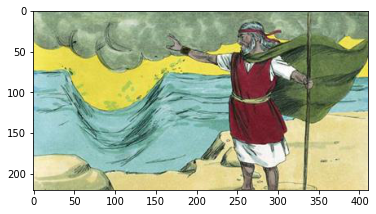

In [69]:
import matplotlib.pyplot as plt
img = plt.imread('./images/840e5442-7fbf-40f5-ad67-7ad1b81d297e.jpg')
plt.imshow(img)
plt.show()

In [70]:
import pandas as pd

test_data = pd.read_csv('../input/purdue-test-dataset/test.csv')
test_data.head()

,Id,ImageURL,ISO639-3
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,https://bloom-vist.s3.amazonaws.com/%D0%A6%D0%...,kir
1,02d89130-e6e5-4aea-88ed-99e100aafe84_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%82%...,tha
2,04763763-d79a-4a97-a529-20c5178d7d2d_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%80%...,tha
3,0478f1ca-3db4-4025-a838-255d45b2c603_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau
4,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir


In [96]:
id_list = test_data.loc[test_data['ISO639-3'] == 'hau']['Id'].to_list()

In [97]:
test_data['Predicted'] = ''

In [98]:
for id in id_list:
    image_url = test_data.loc[test_data['Id'] == id]['ImageURL'].to_list()[0]
    idx = test_data.loc[test_data['Id'] == id].index[0]
    image_path = fetch_single_image(image_url)
    checkpoint = torch.load('./BEST_checkpoint_haudata_1_cap_per_img_5_min_word_freq.pth.tar', map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    with open('./images/WORDMAP_haudata_1_cap_per_img_5_min_word_freq.json', 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}

    seq, alphas = caption_image_beam_search(encoder, decoder,image_path, word_map, 35)
    words = [rev_word_map[ind] for ind in seq]
    print(words)
    new_words = [i for i in words if i != '<start>']
    new_words_1 = [i for i in new_words if i != '<end>']
    new_words_2 = [i for i in new_words_1 if i != '<unk>']
    caption = ' '.join(word for word in new_words_2)
#     print(caption)
    final_caption = translator.translate(caption,dest = 'ha').text
#     print(final_caption)
    
    test_data.iloc[idx]['Predicted'] = final_caption

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


['<start>', 'The', '<unk>', 'is', '<unk>', '<unk>', '<end>']
['<start>', 'Then', 'the', 'Ant', 'Girl', 'was', 'coming', '<end>']
['<start>', 'There', 'are', '<unk>', '<unk>', 'on', 'the', 'ground', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', '<unk>', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', 'Modi', 'will', 'fix', 'it', '<end>']
['<start>', 'Please', 'pay', 'attention', 'Pay', 'attention', 'to', 'the', 'wedding', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', 'Modi', 'will', 'fix', 'it', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', 'Modi', 'will', 'fix', 'it', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', '<end>']
['<start>', 'Then', 'the', 'Ant', 'Girl', 'was', 'very', 'happy', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', '<unk>', '<end>']
['<start>', 'There', 'are', '<unk>', '<unk>', 'on', 'the', '<unk>', '<end>']
['<start>', 'There', 'are', '<unk>', '<unk>', 'on', 'the', 'ground', '<end>']
['<start>', 'The', '<unk>', 'is', '<unk>', '<end>']

In [99]:
test_data.sample(10)

,Id,ImageURL,ISO639-3,Predicted
26,20daeb3b-d1f3-43ce-a1ee-b80008e3f8be_hau,https://bloom-vist.s3.amazonaws.com/01/image10...,hau,Sai Budurwar Ant tayi murna sosai
139,ce1c599d-8fa4-4fcc-b62f-e816095eb757_kir,https://bloom-vist.s3.amazonaws.com/%D0%9A%D0%...,kir,
47,490f3269-0a81-4643-bbbe-f13703bda8de_hau,https://bloom-vist.s3.amazonaws.com/Kyauta%20m...,hau,Modi ne zai gyara shi
5,095b71cc-ef78-4861-af3f-5353c1bfcc59_tha,https://bloom-vist.s3.amazonaws.com/%E0%B8%AB%...,tha,
7,09bb3c0d-e00b-4c6d-978f-218874717a72_tha,https://bloom-vist.s3.amazonaws.com/%E0%B9%80%...,tha,
178,69698865-cbc8-45c0-b6df-90e2b3337c8a_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,
168,8d2e6ebf-97fd-45f3-9665-1cc3431c93ad_tha,https://bloom-vist.s3.amazonaws.com/test/testt...,tha,
46,48be99d1-a017-4aff-af69-8a5fa6d3442e_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau,The
145,d783941b-149d-4078-b02a-2c48de172f6c_hau,https://bloom-vist.s3.amazonaws.com/01/image8.jpg,hau,Fatima ta wuce a
17,1278528d-1cfe-4516-ad37-f700823444dd_hau,https://bloom-vist.s3.amazonaws.com/Gallina%20...,hau,The shine


In [100]:
test_data.to_csv(r'submission.csv',index = False)

In [101]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv